In [20]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import math

from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
LENGTH = 1.
TOTAL_TIME = 1.
N_POINTS_X = 150
N_POINTS_T = 150
N_POINTS_INIT = 300
WEIGHT_INTERIOR = 0.5
WEIGHT_INITIAL = 150.0
WEIGHT_BOUNDARY = 1.0
LAYERS = 2
NEURONS_PER_LAYER = 60
EPOCHS = 50_000
LEARNING_RATE = 0.0025

### Initial condition

In [22]:
def initial_condition(x) -> torch.Tensor:
    res = torch.sin(math.pi*x).reshape(-1,1)
    return res

### PINN

In [23]:
class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh(), pinning: bool = False):

        super().__init__()

        self.pinning = pinning

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x, t):

        x_stack = torch.cat([x, t], dim=1)        
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)

        # if requested pin the boundary conditions 
        # using a surrogate model: (x - 0) * (x - L) * NN(x)
        if self.pinning:
            logits *= (x - x[0]) * (x - x[-1])
        
        return logits

def f(pinn: PINN, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return pinn(x, t)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(pinn: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = f(pinn, x, t)
    return df(f_value, t, order=order)


def dfdx(pinn: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = f(pinn, x, t)
    return df(f_value, x, order=order)

### Splines

In [24]:
import scipy.interpolate as spi

class B_Splines:

  def __init__(self, knot_vector: list):
    self.knot_vector = knot_vector

  # 1D case
  def calculate_BSpline_1D(self, x: torch.Tensor, coef: torch.Tensor, degree: int) -> torch.Tensor:
    return spi.BSpline(self.knot_vector, coef, degree)(x)

  def calculate_BSpline_1D_deriv(self, x: torch.Tensor, coef: torch.Tensor, degree: int, order: int) -> torch.Tensor:
    return spi.splev(x, (self.knot_vector, coef, degree), order)

  # 2D case
  def calculate_BSpline_2D(self, 
                           x1: torch.Tensor,
                           x2: torch.Tensor, 
                           degree_1: int, 
                           degree_2: int,
                           coef_1: torch.Tensor,
                           coef_2: torch.Tensor) -> torch.Tensor:

    first_spline = torch.Tensor(self.calculate_BSpline_1D(x1, coef_1, degree_1))
    second_spline = torch.Tensor(self.calculate_BSpline_1D(x2, coef_2, degree_2))
    return torch.mul(first_spline, second_spline)

      # 2D case
  def calculate_BSpline_2D_deriv_x(self, 
                           x: torch.Tensor,
                           t: torch.Tensor, 
                           degree_x: int, 
                           degree_t: int,
                           coef_x: torch.Tensor,
                           coef_t: torch.Tensor,
                           order: int) -> torch.Tensor:

    first_spline = torch.Tensor(self.calculate_BSpline_1D_deriv(x, coef_x, degree_x, 1))
    second_spline = torch.Tensor(self.calculate_BSpline_1D(t, coef_t, degree_t))
    return torch.mul(first_spline, second_spline)

  def calculate_BSpline_2D_deriv_t(self, 
                           x: torch.Tensor,
                           t: torch.Tensor, 
                           degree_x: int, 
                           degree_t: int,
                           coef_x: torch.Tensor,
                           coef_t: torch.Tensor,
                           order: int) -> torch.Tensor:

    first_spline = torch.Tensor(self.calculate_BSpline_1D(x, coef_x, degree_x))
    second_spline = torch.Tensor(self.calculate_BSpline_1D_deriv(t, coef_t, degree_t, 1))
    return torch.mul(first_spline, second_spline)

eps_interior = 0.001

splines = B_Splines(np.linspace(0, 1, int(1/eps_interior * 5)))
# splines.calculate_BSpline_2D(torch.Tensor([0.5,0.2,0.4]),torch.Tensor([0.5,0.2,0.4]), 2, 2, [1,0,0,0,1,0,0,0,0,0], [1,0,0,0,0,0,1,0,0,0])

### Loss function

In [25]:
def interior_loss(pinn: PINN, x:torch.Tensor, t: torch.tensor, sp: B_Splines = splines):
    global eps_interior
    #t here is x in Eriksson problem, x here is y in Erikkson problem
    # loss = dfdt(pinn, x, t, order=1) - eps*dfdt(pinn, x, t, order=2)-eps*dfdx(pinn, x, t, order=2)


    # degree_1, degree_2 = np.random.randint(low=0, high=3, size=2)
    degree_1, degree_2 = 2, 2
    # coef = np.random.randint(low=0, high=2, size=len(sp.knot_vector))
    # coef_2 = np.random.randint(low=0, high=2, size=len(sp.knot_vector))
    coef_float = np.random.rand(len(sp.knot_vector))
    coef_float_2 = np.random.rand(len(sp.knot_vector))
    v = sp.calculate_BSpline_2D(x.detach(), t.detach(), degree_1, degree_2, coef_float, coef_float_2)
    v_deriv_x = sp.calculate_BSpline_2D_deriv_x(x.detach(), t.detach(), degree_1, degree_2, coef_float, coef_float_2, order=1)
    v_deriv_t = sp.calculate_BSpline_2D_deriv_t(x.detach(), t.detach(), degree_1, degree_2, coef_float, coef_float_2, order=1)
    loss = torch.trapezoid(torch.trapezoid(
        
        dfdx(pinn, x, t, order=1) * v
        + eps_interior*dfdx(pinn, x, t, order=2) * v_deriv_x
        + eps_interior*dfdt(pinn, x, t, order=2) * v_deriv_t
        
        , dx = 0.01), dx = 0.01)


    return loss.pow(2).mean()

def boundary_loss(pinn: PINN, x:torch.Tensor, t: torch.tensor):
    t_raw = torch.unique(t).reshape(-1, 1).detach()
    t_raw.requires_grad = True
    
    boundary_left = torch.ones_like(t_raw, requires_grad=True) * x[0]
    boundary_loss_left = f(pinn, boundary_left, t_raw)

    boundary_right = torch.ones_like(t_raw, requires_grad=True) * x[-1]
    boundary_loss_right = f(pinn, boundary_right, t_raw)

    x_raw = torch.unique(x).reshape(-1, 1).detach()
    x_raw.requires_grad = True

    boundary_top = torch.ones_like(x_raw, requires_grad=True) * t[-1]
    boundary_loss_right = f(pinn, boundary_top, x_raw)


    return boundary_loss_left.pow(2).mean() + boundary_loss_right.pow(2).mean()

def initial_loss(pinn: PINN, x:torch.Tensor, t: torch.tensor):
    # initial condition loss on both the function and its
    # time first-order derivative
    x_raw = torch.unique(x).reshape(-1, 1).detach()
    x_raw.requires_grad = True

    f_initial = initial_condition(x_raw)
    t_initial = torch.zeros_like(x_raw)
    t_initial.requires_grad = True

    initial_loss_f = f(pinn, x_raw, t_initial) - f_initial 
    initial_loss_df = dfdt(pinn, x_raw, t_initial, order=1)

    return initial_loss_f.pow(2).mean() + initial_loss_df.pow(2).mean()

def compute_loss(
    pinn: PINN, x: torch.Tensor = None, t: torch.Tensor = None, 
    weight_f = 1.0, weight_b = 1.0, weight_i = 1.0, 
    verbose = False,
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    final_loss = \
        weight_f * interior_loss(pinn, x, t) + \
        weight_i * initial_loss(pinn, x, t)
    
    if not pinn.pinning:
        final_loss += weight_b * boundary_loss(pinn, x, t)

    if not verbose:
        return final_loss
    else:
        return final_loss, interior_loss(pinn, x, t), initial_loss(pinn, x, t), boundary_loss(pinn, x, t)

### Train function

In [26]:
def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
    device="cpu"
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    loss_values = []
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_values.append(loss.item())
            if (epoch + 1) % 100 == 0:
                print(f"Epoch: {epoch + 1} - Loss: {float(loss):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_values)


def check_gradient(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor) -> bool:

    eps = 1e-4
    
    dfdx_fd = (f(nn_approximator, x + eps, t) - f(nn_approximator, x - eps, t)) / (2 * eps)
    dfdx_autodiff = dfdx(nn_approximator, x, t, order=1)
    is_matching_x = torch.allclose(dfdx_fd.T, dfdx_autodiff.T, atol=1e-2, rtol=1e-2)

    dfdt_fd = (f(nn_approximator, x, t + eps) - f(nn_approximator, x, t - eps)) / (2 * eps)
    dfdt_autodiff = dfdt(nn_approximator, x, t, order=1)
    is_matching_t = torch.allclose(dfdt_fd.T, dfdt_autodiff.T, atol=1e-2, rtol=1e-2)
    
    eps = 1e-2

    d2fdx2_fd = (f(nn_approximator, x + eps, t) - 2 * f(nn_approximator, x, t) + f(nn_approximator, x - eps, t)) / (eps ** 2)
    d2fdx2_autodiff = dfdx(nn_approximator, x, t, order=2)
    is_matching_x2 = torch.allclose(d2fdx2_fd.T, d2fdx2_autodiff.T, atol=1e-2, rtol=1e-2)

    d2fdt2_fd = (f(nn_approximator, x, t + eps) - 2 * f(nn_approximator, x, t) + f(nn_approximator, x, t - eps)) / (eps ** 2)
    d2fdt2_autodiff = dfdt(nn_approximator, x, t, order=2)
    is_matching_t2 = torch.allclose(d2fdt2_fd.T, d2fdt2_autodiff.T, atol=1e-2, rtol=1e-2)
    
    return is_matching_x and is_matching_t and is_matching_x2 and is_matching_t2


### Plotting functions

In [27]:
def plot_solution(pinn: PINN, x: torch.Tensor, t: torch.Tensor, figsize=(8, 6), dpi=100):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)
        
    def animate(i):

        if not i % 10 == 0:
            t_partial = torch.ones_like(x_raw) * t_raw[i]
            f_final = f(pinn, x_raw, t_partial)
            ax.clear()
            ax.plot(
                x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
            )
            ax.set_ylim(-1, 1)
            ax.legend()

    n_frames = t_raw.shape[0]
    return FuncAnimation(fig, animate, frames=n_frames, interval=100, repeat=False)

def plot_color(z: torch.Tensor, x: torch.Tensor, t: torch.Tensor, n_points_x, n_points_t, figsize=(8, 6), dpi=100):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    t_raw = t.detach().cpu().numpy()
    size = int(np.sqrt(z_raw.size))
    X = x_raw.reshape(n_points_t, n_points_x)
    T = t_raw.reshape(n_points_t, n_points_x)
    Z = z_raw.reshape(n_points_t, n_points_x)
    ax.set_title("PINN solution")
    ax.set_xlabel("Time")
    ax.set_ylabel("x")
    ax.set_ylabel("x")
    c = ax.pcolor(T, X, Z)
    fig.colorbar(c, ax=ax)

    return fig

def running_average(y, window=100):
    cumsum = np.cumsum(np.insert(y, 0, 0)) 
    return (cumsum[window:] - cumsum[:-window]) / float(window)

### Running code

### Train data

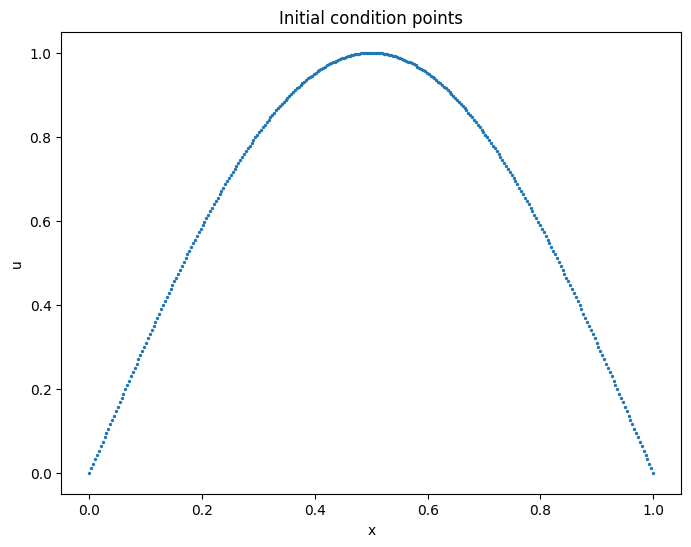

In [28]:
x_domain = [0.0, LENGTH]
t_domain = [0.0, TOTAL_TIME]

x_raw = torch.linspace(x_domain[0], x_domain[1], steps=N_POINTS_X, requires_grad=True)
t_raw = torch.linspace(t_domain[0], t_domain[1], steps=N_POINTS_T, requires_grad=True)
grids = torch.meshgrid(x_raw, t_raw, indexing="ij")

x = grids[0].flatten().reshape(-1, 1).to(device)
t = grids[1].flatten().reshape(-1, 1).to(device)

x_init = torch.linspace(0.0, 1.0, steps=N_POINTS_INIT)
# x_init = 0.5*((x_init-0.5*LENGTH)*2)**3 + 0.5
x_init = x_init*LENGTH
u_init = initial_condition(x_init)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Initial condition points")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.scatter(x_init, u_init, s=2)

In [29]:
def sin_act(x):
    return torch.sin(x)

pinn = PINN(LAYERS, NEURONS_PER_LAYER, pinning=False, act=nn.Tanh()).to(device)
# assert check_gradient(nn_approximator, x, t)

compute_loss(pinn, x=x, t=t)

# train the PINN
loss_fn = partial(compute_loss, x=x, t=t, weight_f=WEIGHT_INTERIOR, weight_i=WEIGHT_INTERIOR, weight_b=WEIGHT_BOUNDARY)
pinn_trained, loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)

Epoch: 100 - Loss: 0.004665
Epoch: 200 - Loss: 0.001063
Epoch: 300 - Loss: 0.000446
Epoch: 400 - Loss: 0.000090
Epoch: 500 - Loss: 0.000256
Epoch: 600 - Loss: 0.000015
Epoch: 700 - Loss: 0.000012
Epoch: 800 - Loss: 0.003640
Epoch: 900 - Loss: 0.000009
Epoch: 1000 - Loss: 0.000008
Epoch: 1100 - Loss: 0.000027
Epoch: 1200 - Loss: 0.000008
Epoch: 1300 - Loss: 0.000007
Epoch: 1400 - Loss: 0.000007
Epoch: 1500 - Loss: 0.000008
Epoch: 1600 - Loss: 0.000006
Epoch: 1700 - Loss: 0.000006
Epoch: 1800 - Loss: 0.001841
Epoch: 1900 - Loss: 0.000006
Epoch: 2000 - Loss: 0.000006
Epoch: 2100 - Loss: 0.000005
Epoch: 2200 - Loss: 0.000664
Epoch: 2300 - Loss: 0.000005
Epoch: 2400 - Loss: 0.000005
Epoch: 2500 - Loss: 0.000253
Epoch: 2600 - Loss: 0.000005
Epoch: 2700 - Loss: 0.000004
Epoch: 2800 - Loss: 0.000004
Epoch: 2900 - Loss: 0.006835
Epoch: 3000 - Loss: 0.000005
Epoch: 3100 - Loss: 0.000004
Epoch: 3200 - Loss: 0.000004
Epoch: 3300 - Loss: 0.000015
Epoch: 3400 - Loss: 0.000005
Epoch: 3500 - Loss: 0.0

In [31]:
losses = compute_loss(pinn.to(device), x=x, t=t, verbose=True)
print(f'Total loss: \t{losses[0]:.5f}    ({losses[0]:.3E})')
print(f'Interior loss: \t{losses[1]:.5f}    ({losses[1]:.3E})')
print(f'Initial loss: \t{losses[2]:.5f}    ({losses[2]:.3E})')
print(f'Bondary loss: \t{losses[3]:.5f}    ({losses[3]:.3E})')

Total loss: 	0.00000    (1.105E-06)
Interior loss: 	0.00000    (0.000E+00)
Initial loss: 	0.00000    (8.658E-07)
Bondary loss: 	0.00000    (2.387E-07)


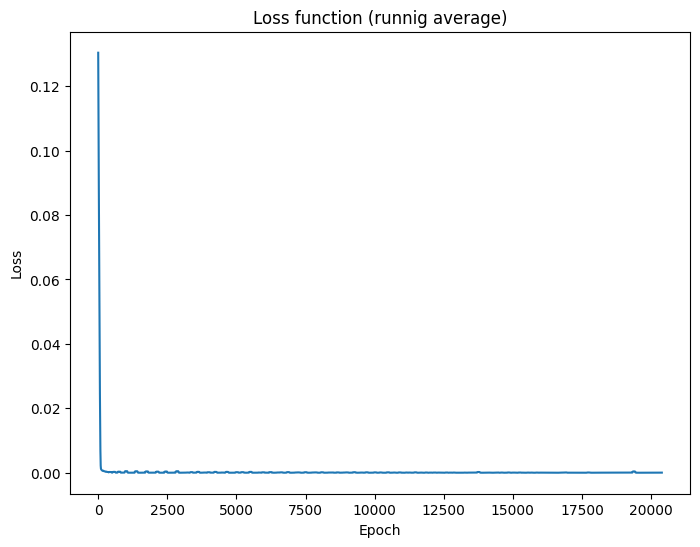

In [32]:
average_loss = running_average(loss_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)

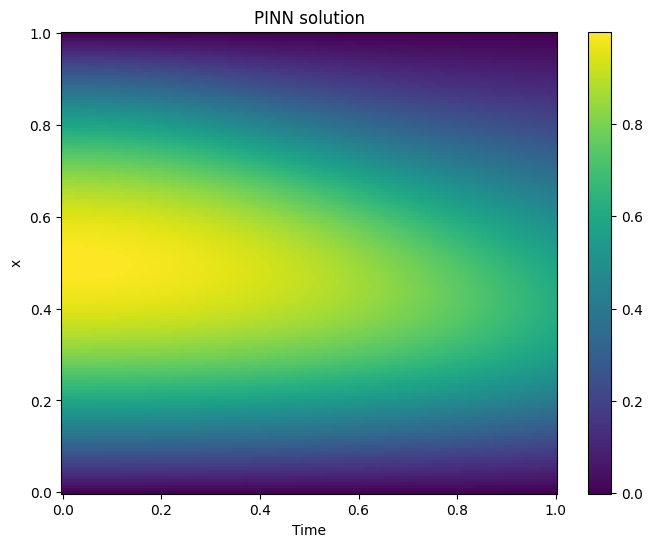

In [33]:
z = f(pinn.to(device), x, t)
color = plot_color(z.cpu(), x.cpu(), t.cpu(), N_POINTS_X, N_POINTS_T)

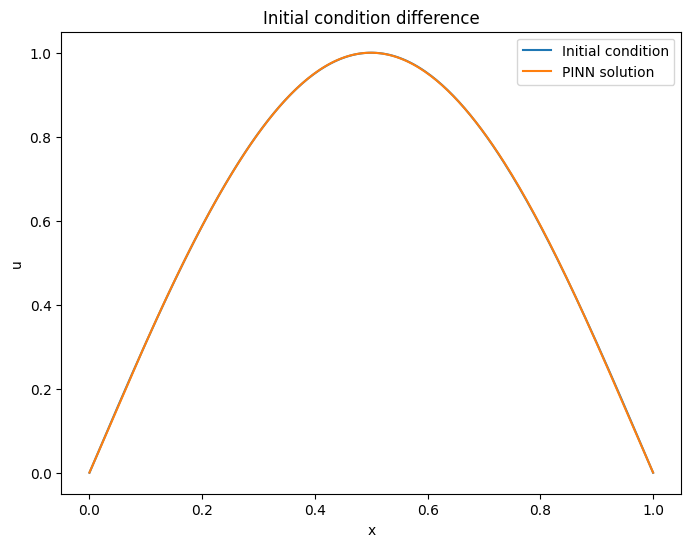

In [34]:
# plt.plot(x_init, u_init, label="Initial condition")
# plt.plot(x_init, pinn_init.flatten().detach(), label="PINN solution")
# plt.legend()

pinn_init = f(pinn.cpu(), x_init.reshape(-1, 1), torch.zeros_like(x_init).reshape(-1,1))
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Initial condition difference")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.plot(x_init, u_init, label="Initial condition")
ax.plot(x_init, pinn_init.flatten().detach(), label="PINN solution")
ax.legend()

In [35]:
# from IPython.display import HTML
# ani = plot_solution(pinn_trained.cpu(), x.cpu(), t.cpu())
# HTML(ani.to_html5_video())

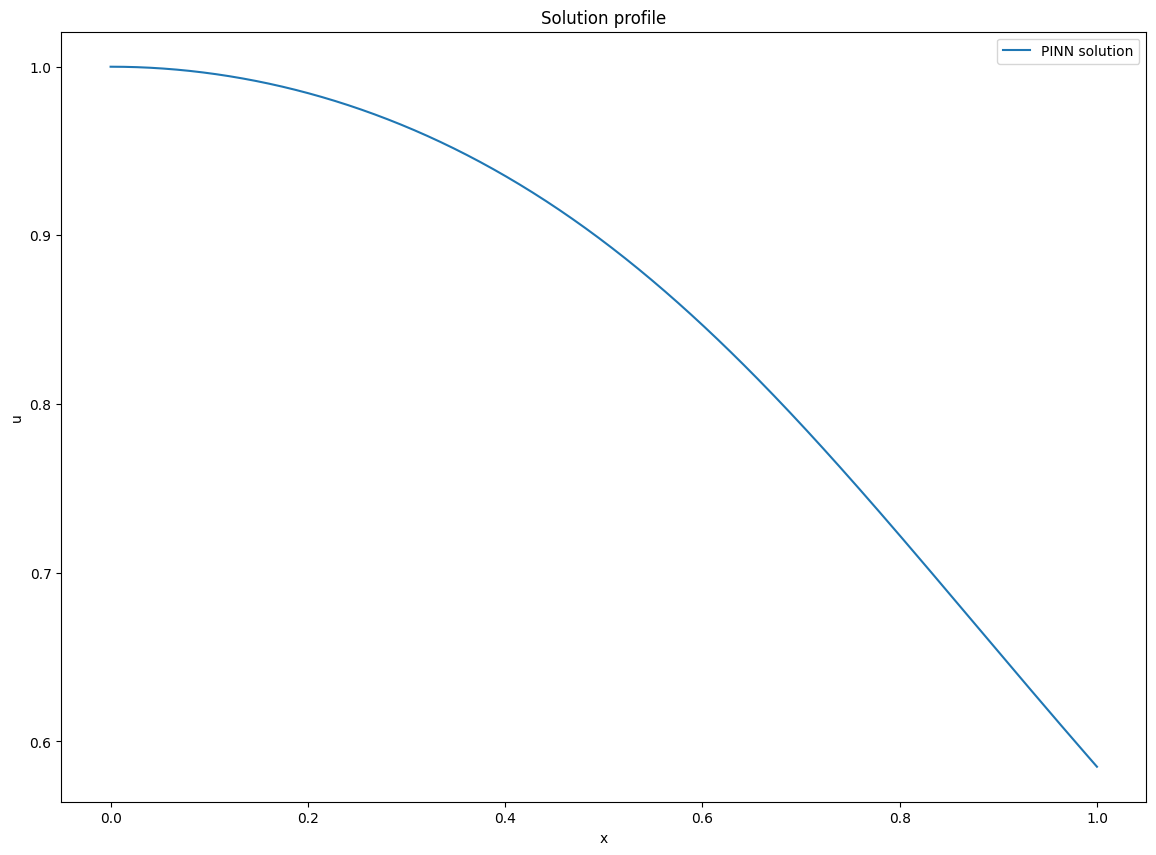

In [36]:
# plt.plot(x_init, u_init, label="Initial condition")
# plt.plot(x_init, pinn_init.flatten().detach(), label="PINN solution")
# plt.legend()

pinn_init = f(pinn.cpu(), torch.zeros_like(x_init).reshape(-1,1)+0.5, x_init.reshape(-1, 1))
fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.set_title("Solution profile")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.plot(x_init, pinn_init.flatten().detach(), label="PINN solution")
ax.legend()